# Mandatory Settings

In [12]:
#INPUT-TABLE-DETAILS:

#Give the name of the input schema
input_table_schema="XXXXX"
#Give the name of input table
input_table_name=" XXXXX" 
#Give the name of the target
target_name='target'

#CHECK FOR CORRELATION MATRIX

#Give a list of variables.
Var= ['entity','region_name','state','cost_amt','cdv', 'offer_play_mix_name','target']


# Importing Libraries


In [ ]:
 %matplotlib notebook
from pyspark.ml import Pipeline
from numpy import allclose
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import *
from pyspark.mllib.stat import *
from pyspark.ml.feature import *
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import time 
import matplotlib
import numpy as np
import pandas as pd
import random
from pyspark.sql.functions import col

# Correlation Matrix Code in Pyspark


<IPython.core.display.Javascript object>


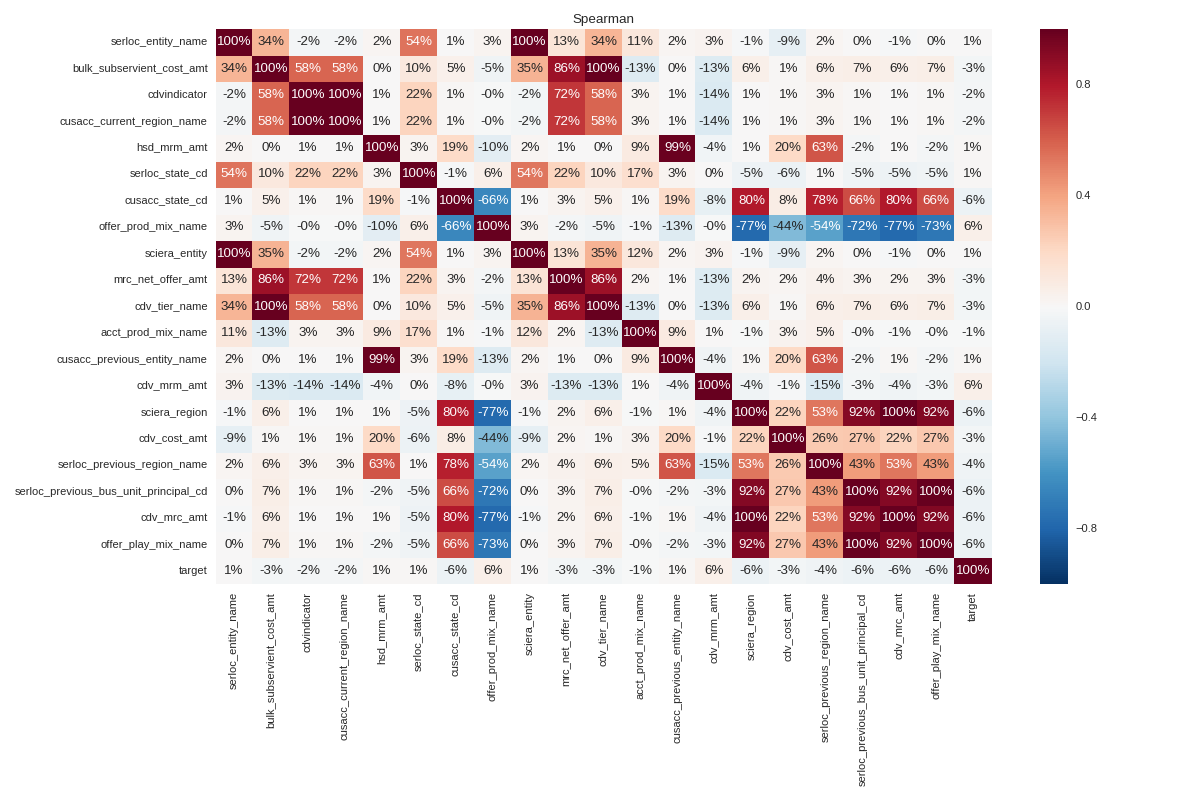

In [14]:
#pulling the input table
df=spark.sql("select * from " +input_table_schema+"."+input_table_name)
df_save1=df.select(Var)

#segmenting variables into numeric and categorical 
vars=df_save1.dtypes
corrcategorical=[]
corrnumeric=[]
for i in xrange(0,len(vars)):
    if vars[i][1]=="string": 
        corrcategorical.append(vars[i][0])
    else:
        corrnumeric.append(vars[i][0])  

#adding the term 'index' at the end of every categorical variable
corrcategorical_index=[]
for i in xrange(0,len(corrcategorical)):
    categoricals=corrcategorical[i]+'_index'
    corrcategorical_index.append(categoricals)
corrcategorical_index 

#for missing values in the varibles are replaced 
df_save1=df_save1.na.fill(0.0)
df_save1=df_save1.na.fill('X')

# create string indexer pipeline to convery the categorical variable
plan_indexer1= [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(corrcategorical))]
pipeline0 = Pipeline(stages=plan_indexer1)
df_r1 = pipeline0.fit(df_save1).transform(df_save1)

#Vector assembler created to assemble both categorical and numeric variables as features for our pipeline.
assembler1 = VectorAssembler( inputCols = corrcategorical_index + corrnumeric , outputCol = 'features')
from pyspark.mllib.linalg import Vectors

#transformed the assembler into an RDD format so that correlation function can be ran 
stat_rdd = assembler1.transform(df_r1).rdd.map(lambda row: row['features'].toArray())

#to deduce the names of the respective variables (save them as columns1) as they are converted into vectors from above steps.
columns1 = df_save1.columns
corr_mat =Statistics.corr(stat_rdd, method="spearman")

#For visualization in a tabular matrix form used the help of python libraries.
import seaborn as sns
f, (ax1) = plt.subplots(1, figsize=(15, 10))
ax1.set_title("Spearman")
sns.heatmap(corr_mat, ax=ax1 ,yticklabels=columns1, xticklabels=columns1, annot=True, fmt='.0%')
import matplotlib.pyplot as plt
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
ax1.figure.tight_layout()
plt.show()   